In [63]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

from esn_module import esn

from multiprocessing.dummy import Pool
from multiprocessing import Lock

import time

path = "/mnt/ceph/fschubert/data/max_lyap_sweep/"

filename = "Entropy_xor_input.npy"

In [64]:
n_sweep_sigm_e = 30
n_sweep_sigm_t = 30

sigm_e = np.linspace(0.,1.5,n_sweep_sigm_e)
sigm_t = np.linspace(0.,.9,n_sweep_sigm_t)

sigm_t_ax = np.linspace(0.,sigm_t[-1]+(sigm_t[-1]-sigm_t[-2]),n_sweep_sigm_t+1)
sigm_e_ax = np.linspace(0.,sigm_e[-1]+(sigm_e[-1]-sigm_e[-2]),n_sweep_sigm_e+1)

n_t_adapt = 150000

n_t_sample = 100000

nbins = 50
bins = np.linspace(-1.,1.,nbins+1)

H_list = np.ndarray((n_sweep_sigm_e,n_sweep_sigm_t,1000))

In [65]:
n_threads = 6

pool = Pool(n_threads)

parallel_it = []

lock_parall = Lock()

for k in range(n_sweep_std_in):#tqdm(range(n_sweep_std_in)):
    for l in range(n_sweep_std_act_target):#tqdm(range(n_sweep_std_act_target)):
        parallel_it.append([lock_parall,k,l])

t0 = time.time()
n_el = 0
             
        
def run_simulation(parameters):
    
    lock,k,l = parameters
    
    global n_el

    lock.acquire()
    n_el += 1

    t_el = (time.time()-t0)/60.

    t_rest = (n_sweep_std_act_target*n_sweep_std_in - n_el)*t_el/n_el

    if t_rest >= 60.:
        str_t_rest = str(int(t_rest/60.)) +  ":" + str(int(t_rest%60.)) + " h"
    else:
        str_t_rest = '{:.2f}'.format(t_rest) + " min"
    print(str(l+k*n_sweep_std_act_target)+"/"+str(n_sweep_std_act_target*n_sweep_std_in) + " " + '{:.2f}'.format((time.time()-t0)/60.) +  " minutes elapsed, approx. " + str_t_rest + " to go")
    lock.release()
    
    
    ESN = esn(sigm_act_target=sigm_t[l],mu_act_target=np.random.normal(0.,0.01,(1000)))
        
    u_in = (np.random.rand(n_t_adapt)<0.5)*2.*sigm_e[k]

    ESN.run_hom_adapt(u_in,show_progress=False)

    u_in = (np.random.rand(n_t_sample)<0.5)*2.*sigm_e[k]

    y_rec = ESN.run_sample(u_in,show_progress=False)

    y_hist = np.ndarray((ESN.N,nbins))
    
    H_list_temp = np.ndarray((ESN.N))
    
    for m in range(ESN.N):
        y_hist[m,:] = np.histogram(y_rec[:,m],bins=bins)[0]/n_t
        ind = np.where(y_hist[m,:]!=0)[0]
        H_list_temp[m] = -(y_hist[m,:][ind]*np.log(y_hist[m,:][ind])).sum()
    
    return H_list_temp

results = pool.map(run_simulation,parallel_it)

pool.close()
pool.join()
    
for i,p in enumerate(parallel_it):
    
    k = p[1]
    l = p[2]
    
    H_list[k,l,:] = results[i]

'''
for k in tqdm(range(n_sweep_sigm_e)):
    for l in tqdm(range(n_sweep_sigm_t)):
        
        ESN = esn(sigm_act_target=sigm_t[l],mu_act_target=np.random.normal(0.,0.01,(1000)))
        
        u_in = (np.random.rand(n_t_adapt)<0.5)*2.*sigm_e[k]
        
        ESN.run_hom_adapt(u_in,show_progress=False)
        
        u_in = (np.random.rand(n_t_sample)<0.5)*2.*sigm_e[k]
        
        y_rec = ESN.run_sample(u_in,show_progress=False)
        
        y_hist = np.ndarray((ESN.N,nbins))
        
        for m in range(ESN.N):
            y_hist[m,:] = np.histogram(y_rec[:,m],bins=bins)[0]/n_t
            ind = np.where(y_hist[m,:]!=0)[0]
            H_list[k,l,m] = -(y_hist[m,:][ind]*np.log(y_hist[m,:][ind])).sum()
'''

0/900 0.00 minutes elapsed, approx. 0.01 min to go
38/900 0.00 minutes elapsed, approx. 0.03 min to go
76/900 0.00 minutes elapsed, approx. 0.02 min to go
114/900 0.00 minutes elapsed, approx. 0.01 min to go
152/900 0.00 minutes elapsed, approx. 0.01 min to go
190/900 0.00 minutes elapsed, approx. 0.02 min to go
1/900 19.61 minutes elapsed, approx. 41:42 h to go
153/900 19.77 minutes elapsed, approx. 36:44 h to go
191/900 19.98 minutes elapsed, approx. 32:58 h to go
77/900 19.99 minutes elapsed, approx. 29:38 h to go
39/900 20.04 minutes elapsed, approx. 26:59 h to go
115/900 20.15 minutes elapsed, approx. 24:51 h to go
2/900 37.09 minutes elapsed, approx. 42:11 h to go
154/900 37.21 minutes elapsed, approx. 39:14 h to go
78/900 37.62 minutes elapsed, approx. 36:59 h to go
192/900 37.66 minutes elapsed, approx. 34:40 h to go
40/900 37.76 minutes elapsed, approx. 32:41 h to go
116/900 37.98 minutes elapsed, approx. 31:0 h to go


KeyboardInterrupt: 

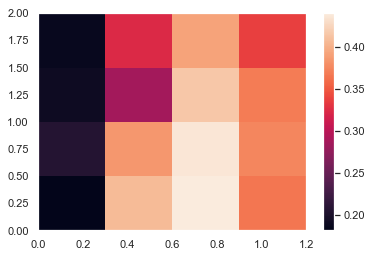

In [53]:
np.save(path+filename,H_list)

In [40]:
H_list.mean(axis=2)

array([[0.27242241, 0.27251584],
       [1.9253577 , 1.92341441]])

In [4]:
ESN.run_hom_adapt(u_in)

100%|██████████| 149999/149999 [00:40<00:00, 3698.43it/s]


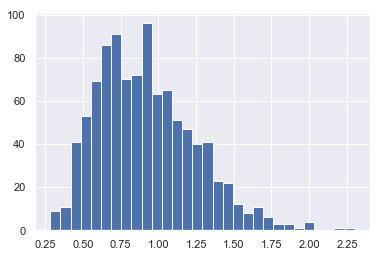

In [5]:
plt.hist(ESN.gain,bins=30)
plt.show()

In [6]:
y_rec = ESN.run_sample(u_in)

100%|██████████| 149999/149999 [00:37<00:00, 3964.04it/s]


In [23]:
nbins = 50
bins = np.linspace(-1.,1.,nbins+1)
y_hist = np.ndarray((ESN.N,nbins))

for k in tqdm(range(ESN.N)):
    y_hist[k,:] = np.histogram(y_rec[:,k],bins=bins)[0]/n_t

In [28]:
H = np.ndarray((ESN.N))

for k in tqdm(range(ESN.N)):
    ind = np.where(y_hist[k,:]!=0)[0]
    H[k] = -(y_hist[k,:][ind]*np.log(y_hist[k,:][ind])).sum()


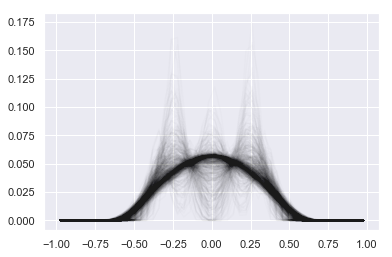

In [24]:
for k in range(ESN.N):
    #plt.step(bins[1:],y_hist[k,:])
    plt.plot(0.5*(bins[:-1]+bins[1:]),y_hist[k,:],c='k',alpha=0.01)
plt.show()

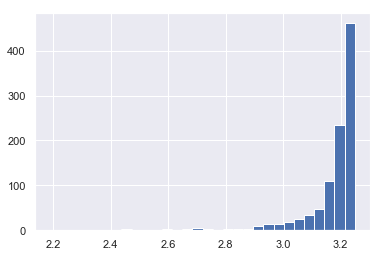

In [31]:
plt.hist(H,bins=30)
plt.show()